# Results
This notebook was created to form the results into more human-freandly form

"Form results table" helps to pork with results_2 for mpipe, smpl, and ntu datasets (The first experiment in the report)

"CV Results" - work with CV results (The second experiment in the report).

In [2]:
%load_ext autoreload
%autoreload 1
%aimport modules.results_auxiliary
# %aimport modules.dataset_auxiliary, modules.classification_auxiliary, modules.ml_auxiliary, modules.bullets, modules.results_auxiliary, modules.bullets

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import copy
import time
import json
import timeit

# from modules.bullets import*
# from modules.classification_auxiliary import *
# from modules.ml_auxiliary import *
from modules.results_auxiliary import *


import pathlib
import seaborn as sns


# Form results table

In [64]:
df

NameError: name 'df' is not defined

In [ ]:
# Input
src = 'stages/results_2-mpipe/'


#script form_table_v2 and form_table_v3
form_table, get_fancy_table = form_table_v2, get_fancy_table_v2
# form_table, get_fancy_table= form_table_v3, get_fancy_table_v2


src_list = get_target_files(src)
df = form_table(src_list)
table = get_fancy_table(df)
df_f = filter_acc(src, drop_classes=[16])
table = table.merge(df_f[['model', 'acc_drop_fancy', 'acc_merge_fancy']], on='model')


# Acc_drop is if geture with label 16 (G17_left_write) was dropped
# Ass_merge is if geture with labels 16(G17_left_write) and 17 (G18_right_write)) are merged into label 17 (G18_right_write)
# (gesture name) from gesture.txt
table



,model,"Accuracy, %","Inference time, ms","Fitting time, s",acc_drop_fancy,acc_merge_fancy
0,SVD_max+KNN: {},36.47,191.324,0.01,36.43,36.47
1,"SVD_max+LogReg: {'class_weight': 'balanced', '...",91.14,0.475,26.83,91.12,91.14
2,"SVD_max+RandForest: {'n_estimators': 300, 'max...",3.08(0.15),77.234,37.61,3.06,3.05
3,SVD_max+STMM: {},71.65(0.16),1.076,948.2,71.67,71.68
4,SVD_max+SVMClassifier: {},91.08,8.53,30.36,91.12,91.08
5,SVD_max+XGBoost: {'n_estimators': 300},70.96,1.887,1433.73,71.07,70.96
6,original+KNN: {},49.4,108.482,0.09,49.28,49.40
7,"original+LogReg: {'class_weight': 'balanced', ...",92.81,0.333,2427.76,92.80,92.81
8,"original+RandForest: {'n_estimators': 300, 'ma...",95.69(0.15),46.871,30.07,96.04,95.99
9,original+STMM: {},95.86(0.17),25.565,2493.14,95.86,95.87


In [ ]:
# # For checking


# file_pkl = src + 'model1-skgest-smpl-center_tucker_full.pkl'
# with open(file_pkl, 'rb') as f:
#     data = pickle.load(f)
            
# preds, y_test = data['preds'], data['y_test']
        

# CV results

Accuracy for mpipe and origin_ffil was skipped


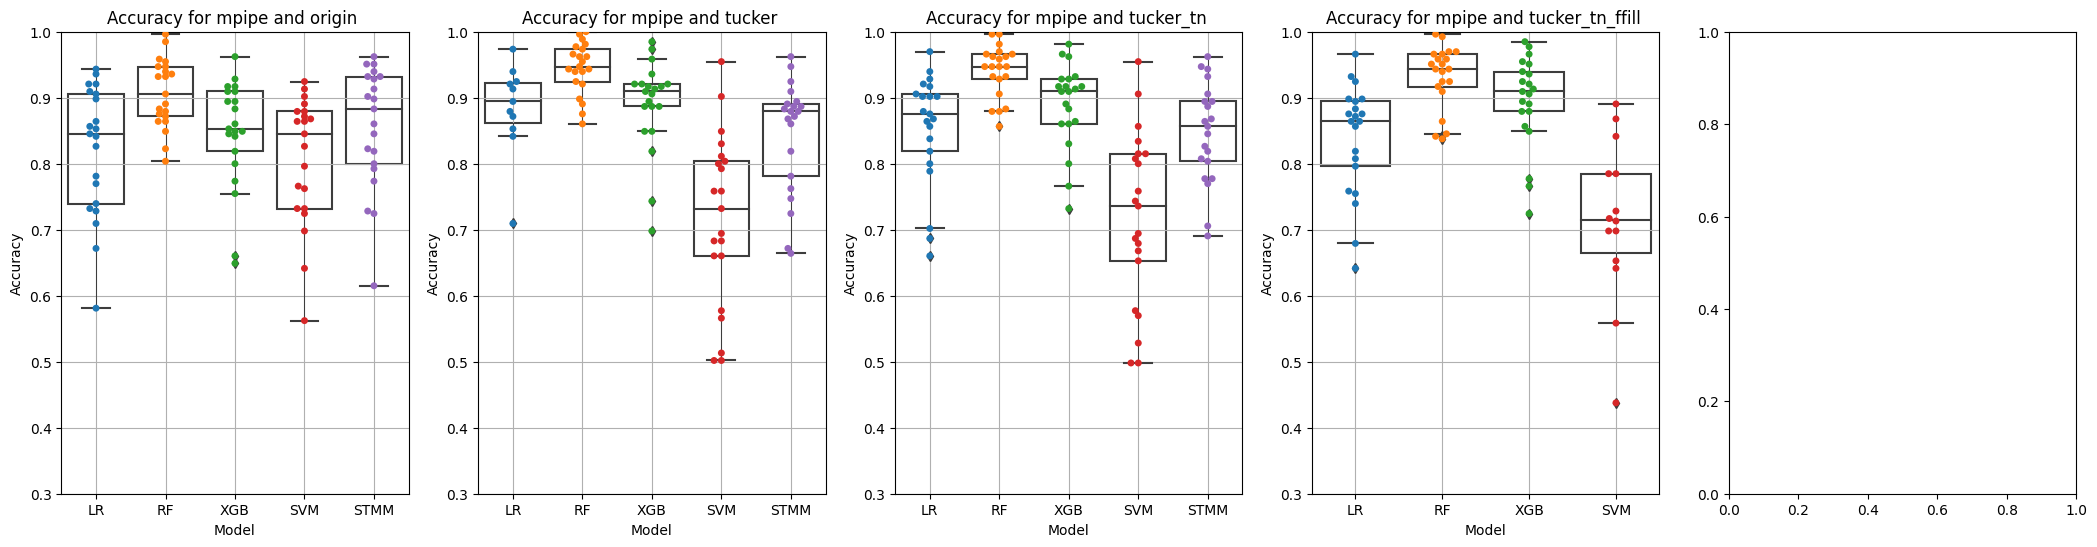

In [48]:
# Gettung plots to CV results

# Input
# Select dataset
# skelet = 'mpipe'
# skelet = 'ntu'
skelet = 'mpipe'

t_src1 = 'stages/results_cv/model{n_model}-skgest-{skelet}-center-folds{transform}.json'
t_src2 = 'stages/results_cv/model{n_model}-skgest-{skelet}-center-folds-fill_0-raw-{transform}.json'
t_src3 = 'stages/results_cv/model{n_model}-skgest-{skelet}-center-folds-ffill-raw-{transform}.json'
# transform_pairs = [['origin', ''], ['tucker', '_tucker_full'], ['svd', '_SVD_max'], ['tucker_tn', 'tucker_full_tn']]


# script
skelets = ['mpipe', 'ntu', 'smpl']


transform_pairs = [['origin', ''], ['tucker', '_tucker_full'], ['tucker_tn', 'tucker_full_tn'], ['tucker_tn_ffill', 'tucker_full_tn'], ['origin_ffil', 'origin']]
                #    ['pca', 'pca_max'], ['svd', '_SVD_max']]
t_src_list = [t_src1,  t_src1, t_src2, t_src3, t_src3]


name_dict = {'LogReg': 'LR', 'RandForest': 'RF', 'XGBoost': 'XGB', 'SVMClassifier':'SVM'}
# name_dict = {'LogReg': 'LR', 'RandForest': 'RF', 'XGBoost': 'XGB', 'SVMClassifier':'SVM', 'STMM':'STMM'}


n = len(transform_pairs)
figure, axes = plt.subplots(1, n, figsize=(5*n+1, 6))
# table_dict = {}

for i, transform_pair in enumerate(transform_pairs):
    ax = axes[i]
    acc_dicts, model_names = [], []
    t_src = t_src_list[i]
    try:
        for n_model in [1, 2, 3, 4, 5]:
            
                src = t_src.format(n_model=n_model, skelet=skelet, transform=transform_pair[1])
                if os.path.exists(src):
                    acc_dict, model_name = collect_accuracy(src)
                    acc_dicts += [acc_dict]
                    model_names += [model_name]
                
        table = form_common_table(acc_dicts, model_names, name_dict=name_dict)
        table_dict[f"{skelet}-{transform_pair[0]}"] = table
        
        plot_swarmboxplot(table, ax=ax,)
        ax.set_ylim([0.3, 1])
        ax.set_title(f"Accuracy for {skelet} and {transform_pair[0]} ")
        ax.grid()
        # plt.show()
                         
    except:
        print(f"Accuracy for {skelet} and {transform_pair[0]} was skipped")
        

In [45]:
len(table_dict.keys())

15

In [46]:
table_dict.keys()

dict_keys(['mpipe-origin', 'mpipe-tucker', 'mpipe-tucker_tn', 'mpipe-tucker_tn_ffill', 'mpipe-origin_ffil', 'ntu-origin', 'ntu-tucker', 'ntu-tucker_tn', 'ntu-tucker_tn_ffill', 'ntu-origin_ffil', 'smpl-origin', 'smpl-tucker', 'smpl-tucker_tn', 'smpl-tucker_tn_ffill', 'smpl-origin_ffil'])

In [47]:
# csv for dmitriy
# I need to run all sleketons and commet "table_dict = {}" from the second run, to collect table_dict woth all skeletons
models = ['LR', 'RF']
for model in models:
    for transform in ['origin', 'tucker', 'tucker_tn']:
        
        data_ = {}
        for skelet in skelets:
            key = f"{skelet}-{transform}"
            table_ = table_dict[key]
            data_[skelet] = table_[table_['Model'] == model]['Accuracy']
        out_tabel = pd.DataFrame(data=data_).round(4)
        out_tabel.to_csv(f"{model}-{transform}.csv", index=False, )
    
    

In [25]:
# mean and std values
f_to_exel = False
for t_pair in transform_pairs:
    transform = t_pair[0]
    _ = print(f"\n{transform}:") if not f_to_exel else None
    for model in ['LR', 'RF', 'XGB', 'SVM', 'STMM']:
        key = f"{skelet}-{transform}"
        table_ = table_dict[key]
        mean_acc = table_[table_['Model'] == model]['Accuracy'].mean()
        std_acc = table_[table_['Model'] == model]['Accuracy'].std(ddof=1)
        print(key, model,  f"{100*mean_acc:.2f}({100*std_acc:.2f})", sep='\t')


origin:
mpipe-origin	LR	82.07(9.84)
mpipe-origin	RF	90.66(5.20)
mpipe-origin	XGB	84.62(8.20)
mpipe-origin	SVM	80.68(9.71)
mpipe-origin	STMM	85.59(9.20)

tucker:
mpipe-tucker	LR	88.37(6.96)
mpipe-tucker	RF	94.50(3.88)
mpipe-tucker	XGB	89.00(6.89)
mpipe-tucker	SVM	71.59(13.02)
mpipe-tucker	STMM	84.35(8.55)

tucker_tn:
mpipe-tucker_tn	LR	85.35(8.45)
mpipe-tucker_tn	RF	94.02(3.93)
mpipe-tucker_tn	XGB	88.89(6.40)
mpipe-tucker_tn	SVM	71.81(13.12)
mpipe-tucker_tn	STMM	84.65(7.58)

pca:
mpipe-pca	LR	32.33(5.76)
mpipe-pca	RF	3.04(0.60)
mpipe-pca	XGB	67.28(7.87)
mpipe-pca	SVM	30.12(5.36)
mpipe-pca	STMM	67.49(6.90)

svd:
mpipe-svd	LR	86.16(7.47)
mpipe-svd	RF	3.16(0.55)
mpipe-svd	XGB	66.81(7.83)
mpipe-svd	SVM	86.40(7.55)
mpipe-svd	STMM	68.28(7.77)


In [26]:
df = table_dict['mpipe-tucker_tn']
df = df[df.Model == 'XGB']
df

In [23]:
a = df['Accuracy']
with open('Accuracy__tucker_tn__XGB.pkl', 'wb') as f:
    pickle.dump(a, f)

In [65]:
# import re
# a = re.search(r"fold-P\d\d", "LogReg: {'max_iter': 3000}fold-P01-tucker_full_tn")
# a